In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
from pathlib import Path

def get_data(path):
    with open(path, "rb") as f:
        dat = f.read()
    return np.frombuffer(dat, dtype=np.uint8).copy()

def get_data_mnist(dir_path, train_size=60000, test_size=10000):
    p = Path(dir_path)

    test = list(p.glob('test_*'))
    train = list(p.glob('train_*'))

    d = 784

    x_test = 1.0 / 255 * get_data(test[0])[0x10:].reshape((10000,d))
    y_test = get_data(test[1])[0x08:].reshape((10000, 1))
    
    x_test = x_test[:test_size, :]
    y_test = y_test[:test_size, :]

    x_train = 1.0 / 255 * get_data(train[0])[0x10:].reshape((60000, d))
    y_train = get_data(train[1])[0x08:].reshape((60000, 1))
    
    x_train = x_train[:train_size,:]
    y_train = y_train[:train_size, :]

    return x_train, y_train, x_test, y_test


[7]


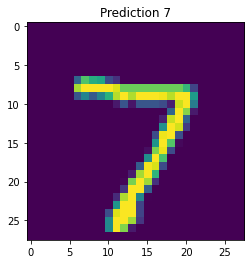

In [4]:
dir_path = "path-to-mnist"

x_train, y_train, x_test, y_test = get_data_mnist(dir_path, 60000, 10000)


print(y_test[0,:])
plt.imshow(x_test[0,:].reshape((28,28)))
plt.title("Prediction " + str(y_test[0,0]))
plt.show()

In [5]:
from scipy.spatial.distance import cdist

def dist(A,B):
    return cdist(A, B).T


def predict(x):

    distances = dist(train_chunk_data, x)
    nearest = np.argmin(distances, axis=1)
    return train_chunk_labels[nearest[:],:]



def conf_matrix(y_true, y_pred, num_classes=10):
    
    C = np.zeros((num_classes, num_classes))

    for i in range(len(y_true)):
        C[y_true[i],y_pred[i]] += 1

    row_sum = C.sum(axis=1)
    
    return C / row_sum[:, None]


def plot_conf_matrix(C, name="output"):
    ax = sn.heatmap(C, annot=True, fmt=".2f", cmap="viridis")
    ax.set(xlabel='Predicted', ylabel='True')
    ax.set(title=name)
    fig = ax.get_figure()
    fig.savefig(name + ".eps")

def plot_image(x, y_pred, y_true, name="plot"):
    ax = plt.imshow(x[:].reshape((28,28)))
    plt.title("Prediction " + str(y_pred) + ", True " + str(y_true))
    fig = ax.get_figure()
    fig.savefig(name + ".eps")


def plot_images(x, y_pred, y_true, name="plot"):
    fig = plt.figure()
    for i in range(x.shape[0]):
        ax = plt.subplot(2,4,i+1,frameon=False, xticks=[], yticks=[])
        plt.imshow(x[i,:].reshape((28,28)))
        plt.title("True " + str(y_true[i]) + ", Pred " + str(y_pred[i]))

    fig.savefig(name + ".eps")


In [6]:
train_chunk_data = x_train[:30000,:]
train_chunk_labels = y_train[:30000,:]

test_nums = x_test[:5000,:]
test_labels = y_test[:5000,:]


y_true = test_labels
y_pred = predict(test_nums)


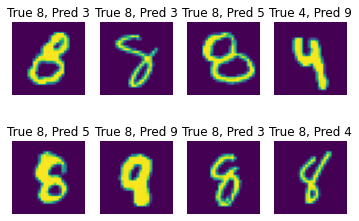

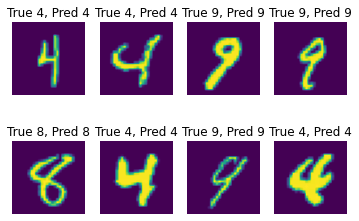

In [7]:

# Extract indices where the true label equals number
numbers=[4,8,9]
true_equals_numbers = (y_true==None).reshape(-1)
for number in numbers:
    true_equals_number = (y_true==number).reshape(-1)
    true_equals_numbers = np.logical_or(true_equals_numbers, true_equals_number)

# Find all wrong predictions and extract those with the number of interest
wrong_prediction_nn = (y_true[:]!=y_pred[:]).reshape(-1)
wrong_prediction_nn = np.logical_and(true_equals_numbers, wrong_prediction_nn)

wrong_labels_nn = y_pred[np.where(wrong_prediction_nn)]
correct_labels_nn = y_true[np.where(wrong_prediction_nn)]
wrong_pitcures_nn =test_nums[np.where(wrong_prediction_nn),:][0,:,:]

ind = 17
#plot_image(wrong_pitcures_nn[ind,:], wrong_labels_nn[ind,0], correct_labels_nn[ind,0])
plot_images(wrong_pitcures_nn[ind:ind+8,:], wrong_labels_nn[ind:ind+8,0], correct_labels_nn[ind:ind+8,0], "incorrect")


# Find all correct predictions and extract those with the number of interest
correct_prediction_nn = (y_true[:]==y_pred[:]).reshape(-1)
correct_prediction_nn = np.logical_and(true_equals_numbers, correct_prediction_nn)

correct_pred_labels_nn = y_pred[np.where(correct_prediction_nn)]
correct_labels_nn = y_true[np.where(correct_prediction_nn)]
correct_pitcures_nn =test_nums[np.where(correct_prediction_nn),:][0,:,:]

ind = 17
#plot_image(wrong_pitcures_nn[ind,:], wrong_labels_nn[ind,0], correct_labels_nn[ind,0])
plot_images(correct_pitcures_nn[ind:ind+8,:], correct_pred_labels_nn[ind:ind+8,0], correct_labels_nn[ind:ind+8,0], "correct")


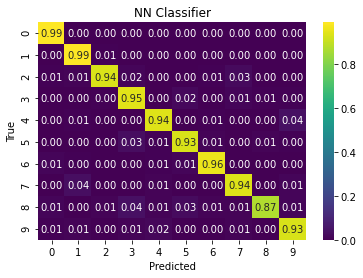

In [8]:
error_rate = 1 - np.sum(y_true[:]==y_pred[:])/y_true.shape[0]

C = conf_matrix(y_true, y_pred)
plot_conf_matrix(C, "NN Classifier")

In [9]:
from sklearn.cluster import KMeans

M = 64
num_classes = 10
data_size = 784

kmeans = KMeans(
n_clusters=M,
init="k-means++",#init="random",
n_init=10,
max_iter=100)#300)
#random_state=42)

In [10]:
template_data = np.zeros((M * num_classes, data_size))

for i in range(num_classes):

    training_class_label = i
    training_class_features = x_train[np.argwhere(y_train.reshape(-1) == i)[:,0]]
    kmeans.fit(training_class_features)

    template_data[M * i: M * (i + 1), :] = kmeans.cluster_centers_



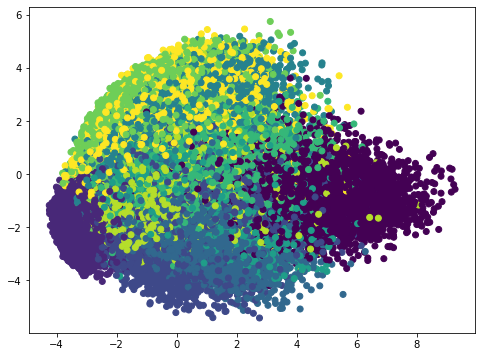

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(x_train)

x_3d = pca.transform(x_train)

#x_3d_classes = np.floor_divide(np.arange(640), M)
x_3d_classes = y_train.reshape(-1)

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c=x_3d_classes)
plt.show()

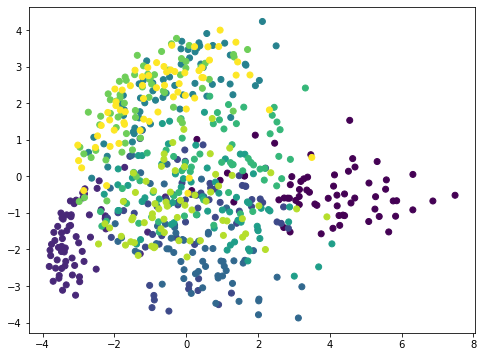

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(template_data)

x_3d = pca.transform(template_data)
x_3d_classes = np.floor_divide(np.arange(640), M)


plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c=x_3d_classes)
plt.show()

In [13]:
distances = None
def predict_cluster(x):
    global distances
    if distances is None:
        distances = dist(template_data, x)
    nearest = np.argmin(distances, axis=1)

    return np.floor_divide(nearest, M).reshape(x.shape[0],1)

    

def mayority_vote(k_nearest_i, k):
    
    k_nearest_distances_i = k_nearest_i[:k]
    k_nearest_classes_i = k_nearest_i[k:]

    (unique_classes, unique_classes_counts) = np.unique(k_nearest_classes_i, return_counts=True)
    # get the different classes that are present in the k nearest region, and their count

    different_counts = np.bincount(unique_classes_counts)
    # get the count of the how many classes has a specific count  

    if different_counts[-1] == 1: # there is only one class with the highest count
        k_class = unique_classes[np.argmax(unique_classes_counts)]

    else:
        # tie between classes

        # find the classes that are at a tie
        tie_classes = unique_classes[unique_classes_counts==len(different_counts)-1]

        # sort the classes by distance
        k_sorted_indexes = np.argsort(k_nearest_distances_i)
        
        # return the class with the smallest distance 
        # that are also in the tie group
        for i in range(k_sorted_indexes.shape[0]):
            nearest_class = k_nearest_classes_i[k_sorted_indexes[i]] 
            if nearest_class in tie_classes:
                k_class = nearest_class
                break  

    return int(k_class)


def predict_knn(x, k):
    global distances
    if distances is None:
        distances = dist(template_data, x)

    # find the classes of the k nearest references, not sorted
    k_nearest_indexes = np.argpartition(distances, k, axis=1)[:,:k]
    print(k_nearest_indexes.shape)
    k_nearest_classes = np.floor_divide(k_nearest_indexes, M)

    # extract the distances from the k nearest refernces
    k_nearest_distances = distances[np.arange(distances.shape[0])[:, None], k_nearest_indexes]

    k_nearest_data = np.concatenate((k_nearest_distances, k_nearest_classes), axis=1)
    
    # predict classes according to majority vote
    predictions = np.apply_along_axis(mayority_vote, 1, k_nearest_data, k)
    return predictions.reshape(-1,1)


In [14]:
y_pred_cluster = predict_cluster(x_test)

error_rate_cluster = 1 - np.sum(y_test[:]==y_pred_cluster[:])/y_test.shape[0]

k = 7

y_pred_knn = predict_knn(x_test, k)

error_rate_knn = 1 - np.sum(y_test[:]==y_pred_knn[:])/y_test.shape[0]



(10000, 7)


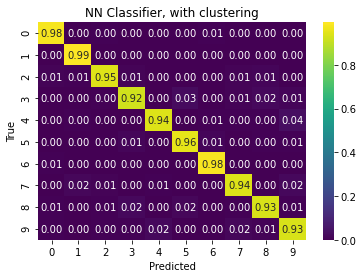

In [15]:
C_cluster = conf_matrix(y_test, y_pred_cluster)
plot_conf_matrix(C_cluster, "NN Classifier, with clustering")

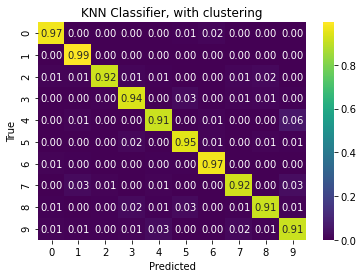

In [16]:
C_knn = conf_matrix(y_test, y_pred_knn)
plot_conf_matrix(C_knn, "KNN Classifier, with clustering")

In [17]:
k_error = []

ks = 10
for k in range(1,ks,2):
    y_pred_k = predict_knn(x_test, k)

    error_rate_k = 1 - np.sum(y_test[:]==y_pred_k[:])/y_test.shape[0]

    k_error.append((k,error_rate_k))


(10000, 1)
(10000, 3)
(10000, 5)
(10000, 7)
(10000, 9)
